In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import scipy
import math
from scipy import special as sp

In [3]:
Nc=2
beta = 2.0

In [4]:
class Jackknife:
    def __init__( self, len_data, binsize ):
        self.binsize = binsize
        self.nbins = math.floor( len_data/self.binsize )
        self.N = self.binsize * self.nbins
        self.jack_avg = []
        self.est = 0
        self.var_est = 0

    def set( self, func, list_of_data ):
        for i in range( self.nbins ):
            self.jack_avg.append( func( i, self.binsize, list_of_data ) )

    def do_it( self ):
        for i in range( 0, self.nbins ):
            self.est += self.jack_avg[i]
        self.est /= self.nbins

        for i in range( 0, self.nbins ):
            self.var_est += ( self.jack_avg[i] - self.est )**2
        self.var_est /= self.nbins
        self.var_est *= self.nbins -1

    def mean( self ):
        return self.est

    def var( self ):
        return self.var_est

    def err( self ):
        return np.sqrt(self.var_est)

def simple_mean(i, binsize, np_data):
    resmpld = np.delete(np_data, np.s_[i*binsize:(i+1)*binsize])
    return np.mean(resmpld)

def format_print(cen, err):
    for i in range(-50, 50):
        if 10**(-i+1)>=err>10**(-i):
            tmp=err*10**(i+1)
            return '{num:.{width}f}'.format(num=cen, width=i+1)+'('+str(round(tmp))+')'

def format_print_w_exact(exact, cen, err):
    for i in range(-50, 50):
        if 10**(-i+1)>=err>10**(-i):
            tmp=err*10**(i+1)
            return '{num:.{width}f}'.format(num=cen, width=i+1)+'('+str(round(tmp))+')'+': '+'{num:.{width}f}'.format(num=(exact-cen)/err, width=i+1)+' sigma'

In [5]:
# fund generators Ta
generators_=[]

for i in range(Nc):
    for j in range(i+1, Nc):
        tmp = np.full((Nc,Nc), 0.0+0.0j)
        tmp[i,j]=1.0
        tmp[j,i]=1.0
        generators_.append(tmp)
        
        tmp = np.full((Nc,Nc), 0.0+0.0j)
        tmp[i,j]=-1.0j
        tmp[j,i]=1.0j
        generators_.append(tmp)

for m in range(1,Nc):
    tmp=[]
    for i in range(Nc):
        if i<m:
            tmp.append(1)
        elif i==m:
            tmp.append(-m)
        else:
            tmp.append(0)
    Hm=np.diag( np.sqrt(2.0)*np.array(tmp)/np.sqrt(m*(m+1)) )
    generators_.append(Hm)        

generators = 0.5j*np.array(generators_)

In [6]:
# structure constants
def f(a,b,c):
    tb = generators[b]
    tc = generators[c]
    ta = generators[a]
    
    comm = tb@tc - tc@tb
    tmp = comm @ ta

    return -2.0 * np.real( tmp.trace() )

In [7]:
# Killing metric
def K(a,b):
    ta = generators[a]
    tb = generators[b]
    return -2.0 * (ta@tb).trace()

In [8]:
# matrix exp
def expM( M_, n_=Nc, ITER_MAX_=1000, TOL_=1.0e-14 ):
    res = np.identity(n_)
    power = np.identity(n_)
    nfact = 1.0
    for i in range(ITER_MAX_):
        nfact /= i+1
        power = M_@power

        if np.isfinite( np.linalg.norm(power) )==False:
            # print( "exp. i=", i, "M_=", repr(M_) )
            print( "instability (E)" )
            assert(False)

        tmp = res
        res = res + power*nfact
        norm = np.linalg.norm(res - tmp)/np.sqrt(n_)
        if norm < TOL_:
            break
    return res

In [9]:
# adj generators F_a
def F( b ):
    res = np.identity(Nc*Nc-1)
    for c in range(Nc*Nc-1):
        for a in range(Nc*Nc-1):
            res[c,a] = f(b,a,c)
    return res

In [10]:
# XF(q) = q^a T_a
def makeXF( q_ ):
    X = np.zeros( (Nc, Nc), np.cfloat )
    for b in range(Nc*Nc-1):
        X += q_[b]*generators[b]
    return X

In [11]:
def makeE(q):
    XFq = makeXF( q )
    res = expM( XFq )
    return res

In [12]:
NA = (Nc*Nc-1)

def coldU():
    return np.identity(Nc)

def hotU():
    qtmp = np.random.rand(NA)
    Etmp = makeE(qtmp)
    return Etmp

In [17]:
al = 0.2
bet = 0.4

# al = 0.0
# bet = 0.0

In [18]:
NA

3

In [19]:
O_KX = np.array([
    [np.cos(al), -np.sin(al), 0.0],
    [np.sin(al), np.cos(al), 0.0],
    [0.0, 0.0, 1.0]
])@np.array([
    [1.0, 0.0, 0.0],
    [0.0, np.cos(bet), -np.sin(bet)],
    [0.0, np.sin(bet), np.cos(bet)]
])

In [20]:
O_KX@np.transpose(O_KX)

array([[ 1.00000000e+00, -3.37725322e-17,  1.13873184e-18],
       [-3.37725322e-17,  1.00000000e+00,  1.62546618e-17],
       [ 1.13873184e-18,  1.62546618e-17,  1.00000000e+00]])

In [21]:
beta=8.0

In [22]:
def S(U0):
    return -beta * np.real( U0.trace() ) / Nc

In [23]:
def dS_da(U0, a):
    du = generators[a]@U0
    return -beta * np.real( du.trace() ) / Nc

def dS(U0):
    res = np.zeros(Nc*Nc-1)
    
    for a in range(Nc*Nc-1):
        res[a] = dS_da(U0, a)
    
    return res

In [24]:
MK = np.array( [2.0, 3.0, 4.0] )

In [25]:
def H(pK, U0):
    return 0.5*pK @ (pK/MK) + S(U0)

In [26]:
def MD1( pK, U0, tau_ ):
    ## 1
    pKH = pK - 0.5*tau_ * O_KX@dS(U0)
    
    ## 2
    rhoX = (pKH/MK)@O_KX
    shldr = np.zeros( (Nc,Nc), np.cfloat )
    for a in range(Nc*Nc-1):
        shldr += generators[a]*rhoX[a]
    UH = expM( 0.5*tau_*shldr ) @ U0
    
    ## 3
    rhoX = (pKH/MK)@O_KX
    shldr = np.zeros( (Nc,Nc), np.cfloat )
    for a in range(Nc*Nc-1):
        shldr += generators[a]*rhoX[a]
    UP = expM( 0.5*tau_*shldr ) @ UH
    
    ## 4
    pKP = pKH - 0.5*tau_ * O_KX@dS(UP)

    return pKP, UP

In [27]:
def MD( pK, U0, tau, nstep ):
    for i in range(nstep):
        pK, U0 = MD1( pK, U0, tau )
    return pK, U0

In [28]:
U1=hotU()

In [29]:
# stot = 1.0
# nstep = 10
# # tau = stot/nstep

In [30]:
def HMC( U_, stot_, nstep_ ):
    tau_ = stot_/nstep_

    # pK_ = np.random.normal(0, 1.0, Nc*Nc-1)
    pK_ = np.zeros( NA )
    for a in range(Nc*Nc-1):
        pK_[a] = np.random.normal(0, np.sqrt(MK[a]) )
    Hin = H(pK_, U_)
    
    pK = np.copy( pK_ )
    U = np.copy( U_ )
    
    pK, U = MD( pK, U, tau_, nstep_ )
    
    Hfi = H(pK, U)
    
    dH = Hfi - Hin
    r = np.random.uniform()
    is_accept = 0.0
    
    if r<np.exp(-dH):
        is_accept = 1.0
    
    else:
        U = np.copy(U_)
    
    return U, is_accept, dH

In [31]:
Nconf = 1000
stot = 1.0
nstep = 2

np.random.seed(1)
U=hotU()

U, is_accept, dH = HMC( U, stot, nstep )


obs = []

c = 0
rate = 0.0
for i in np.arange(Nconf):
    U, is_accept, dH = HMC( U, stot, nstep )
    rate += is_accept
    c+=1
    print(i, is_accept, dH)
    obs.append( np.real( U.trace() ) )

rate /= c
print(rate)

0 1.0 0.125859717989389
1 1.0 0.04478807607379354
2 1.0 -0.02585816566463639
3 1.0 -0.15386163657773455
4 1.0 -0.00047285458447188233
5 1.0 0.018498020842958596
6 1.0 -0.03102827362127858
7 1.0 0.03171192876142381
8 1.0 0.05768938910579724
9 1.0 0.02090512166400771
10 1.0 -0.028716883767049062
11 1.0 -0.058967757946775556
12 1.0 -0.01503782580634283
13 1.0 0.02864183224006034
14 1.0 0.010577618786367537
15 1.0 -0.043877604269688675
16 1.0 0.048341659394139036
17 1.0 -0.011377718000215253
18 1.0 -0.027608175296940374
19 1.0 -0.012501673313932038
20 1.0 0.00790384109861808
21 1.0 -0.01105160922257653
22 1.0 0.021746327212853522
23 1.0 0.05684842430563375
24 1.0 0.03630754710097239
25 1.0 -0.04419295647172117
26 1.0 -0.025718599250351026
27 1.0 0.001994616984025477
28 1.0 0.08328756123510228
29 1.0 -0.08898994502835222
30 1.0 -0.03194433261366836
31 1.0 0.04051853795495397
32 1.0 0.058398059822428294
33 1.0 -0.05704228049547089
34 1.0 0.01212414426880315
35 1.0 -0.031147380149953108
36 1.

(array([  1.,   0.,   2.,   6.,  18.,  26.,  79., 159., 309., 400.]),
 array([-0.13566222,  0.07782389,  0.29131   ,  0.50479611,  0.71828222,
         0.93176833,  1.14525444,  1.35874055,  1.57222666,  1.78571277,
         1.99919888]),
 <BarContainer object of 10 artists>)

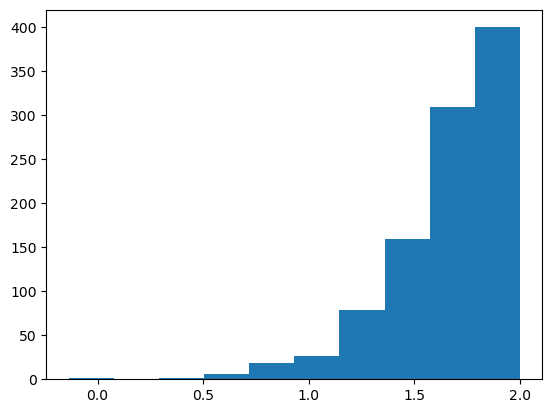

In [32]:
plt.hist(obs)

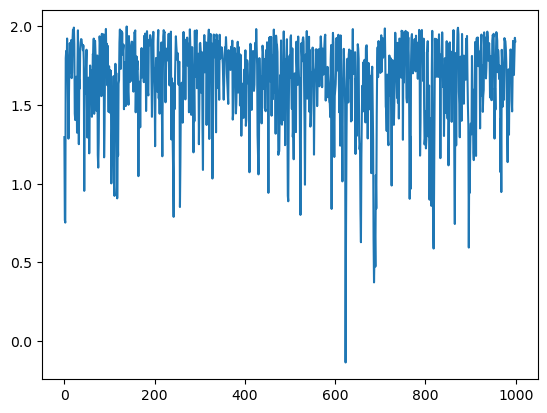

In [33]:
plt.plot(obs)

In [34]:
N = len(obs)
nskip = int(200)
binsize = 10

In [35]:
jk1 = Jackknife( N-nskip, binsize )
jk1.set( simple_mean, obs[nskip:] )
jk1.do_it()

In [36]:
# print("ReTrU", format_print_w_exact( 0.0, jk1.mean(), jk1.err() ))
print("ReTrU", format_print( jk1.mean(), jk1.err() ))

ReTrU 1.648(16)


In [37]:
def get_matrix( Q, lam ):
    mat = np.matrix( [[sp.ive(k-ell+Q+lam[ell], beta/Nc) for ell in range(Nc)] for k in range(Nc)] )
    return mat

def cF( lam ):
    res = np.linalg.det( get_matrix(0, lam) )
    tmp = res
    for Q in range(1,400):
        res += np.linalg.det( get_matrix(Q, lam) )
        res += np.linalg.det( get_matrix(-Q, lam) )
        
        if abs(res-tmp)<1.0e-15:
            break        
        tmp = res
    return res

In [38]:
lam0 = np.zeros(Nc)
lamF = np.zeros(Nc)
lamF[0] = 1

lam2 = np.zeros(Nc)
lam2[0] = 2

analytic = cF( lamF )/cF( lam0 )
analytic2 = cF( lam2 )/cF( lam0 )

In [39]:
analytic

1.6384988207112423

In [40]:
print("ReTrU:", format_print_w_exact( analytic, jk1.mean(), jk1.err() ))

ReTrU: 1.648(16): -0.598 sigma


In [71]:
mulL = expM( 0.5*tau*shldr )
UH = mulL@U

In [77]:
UH@(UH).conjugate().transpose()

array([[1.+1.64651435e-17j, 0.+0.00000000e+00j],
       [0.+0.00000000e+00j, 1.-1.64651435e-17j]])

In [73]:
U

array([[ 0.90692825+0.2221738j ,  0.26078646+0.24517419j],
       [-0.26078646+0.24517419j,  0.90692825-0.2221738j ]])

In [63]:
ds

array([0.49034838, 0.52157291, 0.44434759])

# HMC

$$
S(U) = -{\beta\over N_c} \, {\rm Re}\, {\rm tr}\, U
$$

In [16]:
def S(U, beta=2.0):
    return -beta * np.real( U.trace() )

In [17]:
def makeE(q):
    XFq = makeXF( q )
    res = expM( XFq )
    return res

In [18]:
def makeU(q, U0):
    mat = makeE(q)
    return mat@U0

In [19]:
def dE_dqa(q, a):
    XAq = makeXA( +q )
    Jmq = J( -XAq )
    MatDqaL = np.zeros( (Nc,Nc), np.cfloat )
    for c in range(Nc*Nc-1):
        MatDqaL += generators[c] * Jmq[c,a]

    EFq = makeE(q)
    return MatDqaL @ EFq

In [20]:
def dU_dqa(q, U0, a):
    mat = dE_dqa(q, a)
    return mat@U0

In [21]:
def dS_dqa1(q1, U10, q2, U20, a1):
    dU1 = dU_dqa(q1, U10, a1)
    U2 = makeU(q2, U20)
    return -beta/Nc * np.real( (dU1@U2).trace() )

In [22]:
def dS_dqa2(q1, U10, q2, U20, a2):
    U1 = makeU(q1, U10)
    dU2 = dU_dqa(q2, U20, a2)
    return -beta/Nc * np.real( (U1@dU2).trace() )

In [23]:
NA = (Nc*Nc-1)
# NL = 2

In [24]:
def dS_dq(q1, U10, q2, U20):
    res1 = np.zeros(NA)
    res2 = np.zeros(NA)

    for a in range(NA):
        res1[a] = dS_dqa1(q1, U10, q2, U20, a)
        res2[a] = dS_dqa2(q1, U10, q2, U20, a)
    
    return res1, res2

In [25]:
def make_g(q):
    XAq = makeXA( +q )
    Jmq = J( -XAq )
    matg = Jmq.transpose() @ Jmq
    return matg

In [26]:
def make_ginv(q):
    matg = make_g(q)
    return np.linalg.inv(matg)

In [27]:
def H(p1, q1, U10, p2, q2, U20):
    gI1 = make_ginv(q1)
    gI2 = make_ginv(q2)
    
    kin1 = 0.5 * p1 @ gI1 @ p1
    kin2 = 0.5 * p2 @ gI2 @ p2
    
    U1 = makeU(q1, U10)
    U2 = makeU(q2, U20)

    return kin1 + kin2 + S( U1, U2 )

In [28]:
def dg(q, a):
    XAq = makeXA( +q )
    Jmq = J( -XAq )
    dJmq = -dJ( -q, a )
    tmp = Jmq.transpose() @ dJmq
    return tmp + tmp.transpose()

In [29]:
def dginv(q, a):
    gI = make_ginv(q)
    dgM = dg(q, a)
    return -gI@dgM@gI

In [30]:
def kin(p, q):
    gI = make_ginv(q)
    return 0.5 * p @ gI @ p

In [31]:
def dkin(p, dgIs):
    tmp = np.array( [p @ dgIs[a] @ p for a in range(NA)] )
    return 0.5 * tmp

In [32]:
def coldU():
    return np.identity(Nc)

In [33]:
def coldU():
    return np.identity(Nc)

def hotU():
    qtmp = np.random.rand(NA)
    Etmp = makeE(qtmp)
    return Etmp

In [34]:
def update_p( p, eps_, q, ds, TOL=1.0e-15 ):
    po = np.copy(p)
    pt = np.copy(p)

    dgIs = [ dginv(q, a) for a in range(NA) ]

    pn = p - 0.5*eps_*( dkin(p, dgIs) + ds )
    norm = np.linalg.norm( pn-pt )

    while norm > TOL * np.sqrt(Nc*Nc-1.0):
        pt = np.copy(pn)
        pn = p - 0.5*eps_*( dkin(pt, dgIs) + ds )
        norm = np.linalg.norm( pn-pt )

    return pn

In [35]:
def update_q( q, eps_, p_half, TOL=1.0e-15 ):
    qo = np.copy(q)
    qt = np.copy(q)

    gIo = make_ginv(qo)
    gIt = make_ginv(qt)

    qn = q + 0.5*eps_*( gIo@p_half + gIt@p_half )
    norm = np.linalg.norm( qn-qt )

    while norm > TOL * np.sqrt(Nc*Nc-1.0):
        qt = np.copy(qn)
        gIt = make_ginv(qt)
        qn = q + 0.5*eps_*( gIo@p_half + gIt@p_half )
        norm = np.linalg.norm( qn-qt )

    return qn

In [36]:
def get_ptilde( q, p ):
    XAq = makeXA( +q )
    Jmq = J( -XAq )
    JmqInv = np.linalg.inv(Jmq)
    return p@JmqInv

    # matginv = make_ginv(q)
    # mat = scipy.linalg.sqrtm(matginv)
    # return mat@p

In [37]:
def run_MD(q1, p1, U10, q2, p2, U20, eps_, Nstep_):
    for ell in range(Nstep_):
        ds1, ds2 = dS_dq(q1,U10,q2,U20)
        p1_half = update_p( p1, eps_, q1, ds1 )
        p2_half = update_p( p2, eps_, q2, ds2 )

        q1 = update_q( q1, eps_, p1_half )
        q2 = update_q( q2, eps_, p2_half )
    
        ds1, ds2 = dS_dq(q1,U10,q2,U20)
        p1 = update_p( p1_half, eps_, q1, ds1 )
        p2 = update_p( p2_half, eps_, q2, ds2 )
    
    return q1, p1, q2, p2

In [38]:
def run_HMC_w_switch(U10_, U20_, eps_, Nsafe_, Ntot_):
    q1 = np.zeros( NA )
    q2 = np.zeros( NA )
    p1 = np.random.normal(0, 1.0, NA)
    p2 = np.random.normal(0, 1.0, NA)
    U1 = np.copy(U10_)
    U2 = np.copy(U20_)
    
    q10 = np.copy( q1 )
    p10 = np.copy( p1 )
    q20 = np.copy( q2 )
    p20 = np.copy( p2 )
    
    Hin = H(p1,q1,U1, p2,q2,U2)

    nsteps = 0
    Nblock = 0
    while nsteps < Ntot_:
        if nsteps + Nsafe_ < Ntot_:
            Nblock = Nsafe_
        else:
            Nblock = Ntot_-nsteps
            
        q1, p1, q2, p2 = run_MD(q1, p1, U1, q2, p2, U2, eps_, Nblock)
        nsteps += Nblock

        p1 = get_ptilde( q1, p1 )
        p2 = get_ptilde( q2, p2 )
        
        U1 = makeU(q1, U1)
        U2 = makeU(q2, U2)
        # print("U=",U)
        q1 = np.zeros( Nc*Nc-1)
        q2 = np.zeros( Nc*Nc-1)

    Hfi = H(p1,q1,U1, p2,q2,U2)
    dH = Hfi - Hin
    
    r = np.random.uniform()
    is_accept = 0.0

    if r<np.exp(-dH):
        is_accept = 1.0

    else:
        U1 = np.copy(U10_)
        U2 = np.copy(U20_)
    
    return U1, U2, is_accept, dH

In [48]:
Nconf = 20000

In [49]:
np.random.seed(1)
U1=coldU()
U2=coldU()

In [50]:
obs = []

c = 0
rate = 0.0
for i in np.arange(Nconf):
    U1, U2, flag, dH = run_HMC_w_switch(U1, U2, 0.5, 1, 20)
    rate += flag
    c+=1
    print(i, flag, dH)
    obs.append( np.real( (U1@U2).trace() ) )

rate /= c
print(rate)

0 0.0 0.7054392004326395
1 1.0 0.41115974718421855
2 0.0 0.20384861320155379
3 1.0 -0.04982372430285187
4 1.0 0.1673385756908008
5 1.0 0.09613552059501806
6 1.0 -0.1981186307973033
7 1.0 0.5827895906286686
8 1.0 -0.292194101868696
9 1.0 0.06513226763113211
10 1.0 0.3063327002783578
11 1.0 -0.015677078839329894
12 1.0 -0.3621180424608532
13 1.0 0.202691087377751
14 1.0 0.0354744738879571
15 1.0 -0.24822567553944452
16 1.0 -0.1668387455882887
17 0.0 0.2425979338362083
18 1.0 0.04582726943077642
19 1.0 -0.12763542239285464
20 1.0 -0.10919027059926689
21 1.0 -0.21460651937611885
22 0.0 0.35444611780190716
23 1.0 0.08612432295518069
24 1.0 0.526391839156398
25 1.0 -0.17292076078266572
26 1.0 -0.12853914127475052
27 1.0 -0.011349974485987069
28 1.0 -0.02623104515381325
29 1.0 0.1990736306103651
30 1.0 0.012647035145270102
31 1.0 0.02740581387628893
32 1.0 -0.1154587800022231
33 1.0 -0.07137569671632926
34 1.0 -0.08604385945979987
35 1.0 0.45381929955012
36 1.0 0.11084165304897198
37 1.0 0.00


KeyboardInterrupt



In [54]:
rate /= c

In [55]:
rate

0.9106876553438277

(array([  33.,  160.,  260.,  483.,  787., 1070., 1341., 1175.,  644.,
          82.]),
 array([-1.17326628, -0.75593966, -0.33861303,  0.0787136 ,  0.49604023,
         0.91336686,  1.33069349,  1.74802011,  2.16534674,  2.58267337,
         3.        ]),
 <BarContainer object of 10 artists>)

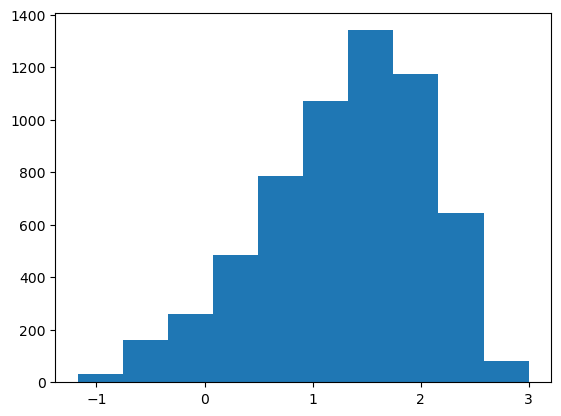

In [56]:
plt.hist(obs)

In [76]:
np.log(0.7)

-0.35667494393873245

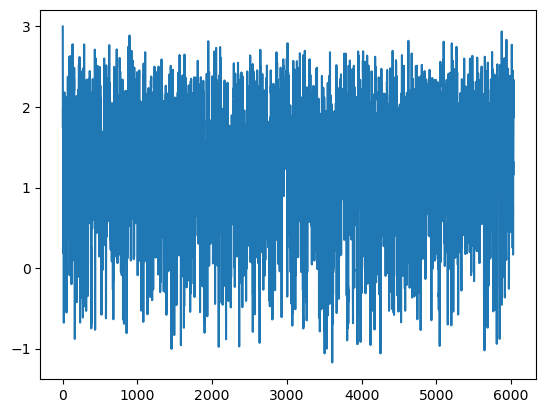

In [57]:
plt.plot(obs)

In [67]:
N = len(obs)
nskip = int(3000)
binsize = 50

In [68]:
jk1 = Jackknife( N-nskip, binsize )
jk1.set( simple_mean, obs[nskip:] )
jk1.do_it()

In [69]:
# print("ReTrU", format_print_w_exact( 0.0, jk1.mean(), jk1.err() ))
print("ReTrU", format_print( jk1.mean(), jk1.err() ))

ReTrU 1.296(25)


In [70]:
def get_matrix( Q, lam ):
    mat = np.matrix( [[sp.ive(k-ell+Q+lam[ell], beta/Nc) for ell in range(Nc)] for k in range(Nc)] )
    return mat

def cF( lam ):
    res = np.linalg.det( get_matrix(0, lam) )
    tmp = res
    for Q in range(1,400):
        res += np.linalg.det( get_matrix(Q, lam) )
        res += np.linalg.det( get_matrix(-Q, lam) )
        
        if abs(res-tmp)<1.0e-15:
            break        
        tmp = res
    return res

In [71]:
lam0 = np.zeros(Nc)
lamF = np.zeros(Nc)
lamF[0] = 1

analytic = cF( lamF )/cF( lam0 )

In [72]:
analytic

1.2675952189499513

In [73]:
print("ReTrU:", format_print_w_exact( analytic, jk1.mean(), jk1.err() ))

ReTrU: 1.296(25): -1.130 sigma


In [74]:
beta, analytic, jk1.mean(), jk1.err()

(6.0, 1.2675952189499513, 1.2962487577778157, 0.025350440288093867)

# SU(2)

In [52]:
res_su2=np.array([
    [8.0, 1.6384988207112423, 1.6272915261691956, 0.018285581396711104],
    [10.0, 1.7083706166473636, 1.7151591156288197, 0.00944362819206844],
    [12.0, 1.7556982571374748, 1.763673837081942, 0.006506003524460866]
])

# SU(3)

In [53]:
res_su3=np.array([
    [12.0, 1.7556982571374748, 1.763673837081942, 0.006506003524460866]
])

FOR SU(2):

$$
e^{\beta/2 \, {\rm Re} {\rm tr}\, U}
=
\sum_j d_j \lambda_j(\beta) \chi_j(U)
$$
$$
d_j = 2j+1
$$
$$
\lambda_j = I_{2j+1}(\beta)/(\beta/2)
$$

$$
Z = \int(dU)\, e^{\beta/2 \, {\rm Re} {\rm tr}\, U} = d_0 \lambda_0 = 2I_1(\beta)/\beta
$$

$$
Z1 = \int(dU)\, e^{\beta/2 \, {\rm Re} {\rm tr}\, U} \chi_{1/2}(U) = d_{1/2} \lambda_{1/2} = 4 I_2(\beta)/\beta
$$

In [54]:
import scipy
import math
from scipy import special as sp

In [55]:
numer = 4.0 * sp.ive( 2, beta )
denom = 2.0 * sp.ive( 1, beta )
analytic = numer/denom
print(analytic)

1.5254521514983839
